# Computer Vision 2022 1st Lab - Part 1: Edge Detection in Gray Images<br>

Ηλιόπουλος Γεώργιος: 03118815 <br>
Σερλής Αναστάσιος Εμανουήλ - 03118125

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#Η ζητούμενη συνάρτηση εντοπισμού ακμών(1.2)

def EdgeDetect (img, s, theta, lapl):
    
    kern = np.array([ #kern is B
            [0,1,0],
            [1,1,1],
            [0,1,0]
        ], dtype=np.uint8)
    
    if lapl == 1:
        sigma = s
        n = int(2 * np.ceil(3 * sigma) + 1)
        gauss1D = cv2.getGaussianKernel(n, sigma) # Column vector
        gauss2D = gauss1D @ gauss1D.T # Symmetric gaussian kernel
        blur_lapl = cv2.Laplacian(gauss2D, cv2.CV_64F)
        L = cv2.filter2D(img, -1, blur_lapl)
        
    if lapl == 2:    
        
        sigma = s
        n = int(2 * np.ceil(3 * sigma) + 1)
        gauss1D = cv2.getGaussianKernel(n, sigma) # Column vector
        gauss2D = gauss1D @ gauss1D.T # Symmetric gaussian kernel
        global img_smooth
        img_smooth = cv2.filter2D(img, -1, gauss2D)
        
        dilated_img = cv2.dilate(img_smooth, kern)
        eroded_img = cv2.erode(img_smooth, kern)
        L = dilated_img + eroded_img - 2 * img
        
#    if lapl != 1 & lapl !=2:
#        print("You must give 4th input as 1 if you want Linear Laplacian or as 2 if you want non-linear Laplacian")
        
    X = np.where(L >= 0, L, 0.0) #if L(x,y)>=0 let it be otherwise set it to 0
    Y = cv2.dilate(X, kern) - cv2.erode(X, kern)
    ZC = np.where(Y == 0.0, 0.0, 1.0)

    sigma = s
    n = int(2 * np.ceil(3 * sigma) + 1)
    gauss1D = cv2.getGaussianKernel(n, sigma) # Column vector
    gauss2D = gauss1D @ gauss1D.T # Symmetric gaussian kernel
    img_smooth = cv2.filter2D(img, -1, gauss2D)
    
    Is_x = np.gradient(img_smooth, axis=0)
    Is_y = np.gradient(img_smooth, axis=1)

    grad_Is = np.sqrt(Is_x ** 2 + Is_y ** 2)

    M = np.max(grad_Is)

    X = np.where((grad_Is > theta * M) & (ZC == 1.0), 1.0, 0.0)
  
    return (X)

C:\Users\grgsl\anaconda3\envs\cv_lab1_env\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


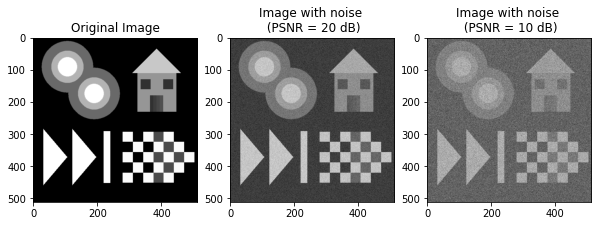

In [3]:
#εισαγωγή εικόνας τεστ και προσθήκη θορύβου (1.1)

img = cv2.imread('edgetest_22.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float)/255

#adding noise PSNR = 10
PSNR = 10
Imax = np.max(img)
Imin = np.min(img)
sigma = (Imax - Imin)/(10**(PSNR/20))

row = 512
col = 512
mean = 0
var = sigma**2
gauss = np.random.normal(mean,sigma,(row,col))
gauss = gauss.reshape(row,col)
noisy1 = img + gauss

#adding noise PSNR = 20
PSNR = 20
Imax = np.max(img)
Imin = np.min(img)
sigma = (Imax - Imin)/(10**(PSNR/20))

row = 512
col = 512
mean = 0
var = sigma**2
gauss = np.random.normal(mean,sigma,(row,col))
gauss = gauss.reshape(row,col)
noisy2 = img + gauss

fig, ax = plt.subplots(1, 3, figsize = (10,30))
ax[0].imshow(img, cmap='gray_r')
ax[2].imshow(noisy1, cmap='gray_r')
ax[1].imshow(noisy2, cmap='gray_r')
ax[0].set_title("Original Image");
ax[2].set_title("Image with noise \n (PSNR = 10 dB)");
ax[1].set_title("Image with noise \n (PSNR = 20 dB)");

theta edge = 0.2
Outputs of noisy image:


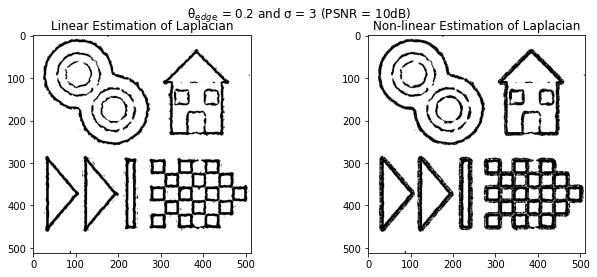

In [4]:
#εφαρμογή της συνάρτησης στην εικόνα με θόρυβο

theta = 0.2
s = 3
K1 = EdgeDetect(noisy1, s, theta, 1)
K2 = EdgeDetect(noisy1, s, theta, 2)
print ("theta edge =", theta)
print ("Outputs of noisy image:")

plt.figure(figsize=(11,4))
plt.subplot(1, 2, 1)
plt.imshow(K1, cmap='gray_r')
plt.title("Linear Estimation of Laplacian");

plt.subplot(1, 2, 2)
plt.imshow(K2, cmap='gray_r')
plt.title("Non-linear Estimation of Laplacian");
plt.suptitle('θ$_e$$_d$$_g$$_e$ = %.1f' %theta + ' and σ = %.f' %s + ' (PSNR = 10dB)');
plt.show()

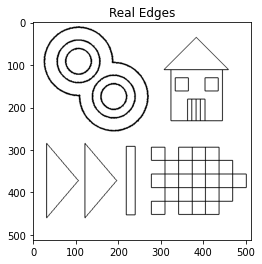

In [5]:
#Finding the real edges in the image without the noise (1.3.1)

kern = np.array([ #kern is B
            [0,1,0],
            [1,1,1],
            [0,1,0]
        ], dtype=np.uint8)
real_edges = cv2.dilate(img, kern) - cv2.erode(img, kern)
real_edges = np.where((real_edges > 0.01), 1.0, 0.0)
plt.imshow(real_edges, cmap='gray_r')
plt.title('Real Edges');

0.5997467784513961 (κριτήριο ποιότητας)


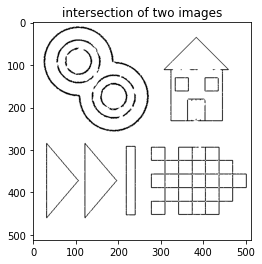

In [6]:
#(1.3.2)
#σύγκριση των ακμών που βρέθηκαν με την συνάρτηση στην εικόνα με θόρυβο με τις πραγματικές ακμές
#και εξαγωγή αντιπροσωπευτικού ποσοστού

D = K2
T = real_edges
intersection = cv2.bitwise_and(D, T)
plt.imshow(intersection, cmap = 'gray_r')
Pr_D_T = np.sum(intersection) / np.sum(D)
Pr_T_D = np.sum(intersection) / np.sum(T)
C = (Pr_D_T + Pr_T_D) / 2
print(C, '(κριτήριο ποιότητας)')
plt.title ("intersection of two images");

In [7]:
#1.3.3
#loop to find the optimal sigma - theta combination (PSNR = 10dB - Linear Laplace)

T = real_edges
sigma = np.linspace(1,3.5,20)
theta = np.linspace(0.01, 0.5, 20)
#sigma = [2, 2.6, 2.65, 2.55, 2.7, 2.45, 3, 3.1, 3.2, 3.5]
#theta = [0.1, 0.15, 0.2, 0.25, 0.4, 0.6, 0.9, 1, 1.5, 2]
C1 = 0
for i in range(20):
    for j in range(20):
        s = sigma[i]
        t = theta[j]
        D = EdgeDetect(noisy1, s, t, 1)
        intersection = cv2.bitwise_and(D, T)
        if np.sum(D) != 0 and np.sum(T) != 0:
            Pr_D_T = np.sum(intersection) / np.sum(D)
            Pr_T_D = np.sum(intersection) / np.sum(T)
            C = (Pr_D_T + Pr_T_D) / 2
            if C > C1:
                C1 = C
                s1 = s
                t1 = t
print("Optimal combo for PSNR = 10dB and Linear Laplacian is theta = %.2f" % t1 + " and s = %.2f" % s1 + " --> C = %.3f" % C1)

Optimal combo for PSNR = 10dB and Linear Laplacian is theta = 0.19 and s = 2.32 --> C = 0.654


In [8]:
#loop to find the optimal sigma - theta combination (PSNR = 10dB - non-Linear Laplace)

T = real_edges
sigma = np.linspace(1,3.5,20)
theta = np.linspace(0.01, 0.5, 20)
#sigma = [2, 2.05, 2.1, 2.15, 2.4, 2.45, 3, 3.1, 3.2, 3.5]
#theta = [0.1, 0.15, 0.2, 0.25, 0.4, 0.6, 0.9, 1, 1.5, 2]
C1 = 0
for i in range(10):
    for j in range(10):
        s = sigma[i]
        t = theta[j]
        D = EdgeDetect(noisy1, s, t, 2)
        intersection = cv2.bitwise_and(D, T)
        if np.sum(D) != 0 and np.sum(T) != 0:
            Pr_D_T = np.sum(intersection) / np.sum(D)
            Pr_T_D = np.sum(intersection) / np.sum(T)
            C = (Pr_D_T + Pr_T_D) / 2
            if C > C1:
                C1 = C
                s1 = s
                t1 = t
print("Optimal combo for PSNR = 10dB and non-Linear Laplacian is theta = %.2f" % t1 + " and s = %.2f" % s1 + " --> C = %.3f" % C1)

Optimal combo for PSNR = 10dB and non-Linear Laplacian is theta = 0.19 and s = 2.18 --> C = 0.617


In [9]:
#loop to find the optimal sigma - theta combination (PSNR = 20dB - Linear Laplace)

T = real_edges
sigma = np.linspace(1,3.5,20)
theta = np.linspace(0.01, 0.5, 20)
#sigma = [2, 2.2, 2.1, 2.15, 2.4, 2.25, 2.3, 2.4, 1.5, 3.5]
#theta = [0.1, 0.15, 0.2, 0.25, 0.4, 0.6, 0.9, 1, 1.5, 2]
C1 = 0
for i in range(10):
    for j in range(10):
        s = sigma[i]
        t = theta[j]
        D = EdgeDetect(noisy2, s, t, 1)
        intersection = cv2.bitwise_and(D, T)
        if np.sum(D) != 0 and np.sum(T) != 0:
            Pr_D_T = np.sum(intersection) / np.sum(D)
            Pr_T_D = np.sum(intersection) / np.sum(T)
            C = (Pr_D_T + Pr_T_D) / 2
            if C > C1:
                C1 = C
                s1 = s
                t1 = t
print("Optimal combo for PSNR = 20dB and Linear Laplacian is theta = %.2f" % t1 + " and s = %.2f" % s1 + " --> C = %.3f" % C1)

Optimal combo for PSNR = 20dB and Linear Laplacian is theta = 0.14 and s = 1.13 --> C = 0.785


In [10]:
#loop to find the optimal sigma - theta combination (PSNR = 20dB - non-Linear Laplace)

T = real_edges
sigma = np.linspace(1,3.5,20)
theta = np.linspace(0.01, 0.5, 20)
#sigma = [1.1, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 3.2, 3.5]
#theta = [0.1, 0.15, 0.2, 0.25, 0.4, 0.6, 0.9, 1, 1.5, 2]
C1 = 0
for i in range(10):
    for j in range(10):
        s = sigma[i]
        t = theta[j]
        D = EdgeDetect(noisy2, s, t, 2)
        intersection = cv2.bitwise_and(D, T)
        if np.sum(D) != 0 and np.sum(T) != 0:
            Pr_D_T = np.sum(intersection) / np.sum(D)
            Pr_T_D = np.sum(intersection) / np.sum(T)
            C = (Pr_D_T + Pr_T_D) / 2
            if C > C1:
                C1 = C
                s1 = s
                t1 = t
print("Optimal combo for PSNR = 20dB and non-Linear Laplacian is theta = %.2f" % t1 + " and s = %.2f" % s1 + " --> C = %.3f" % C1)

Optimal combo for PSNR = 20dB and non-Linear Laplacian is theta = 0.14 and s = 1.13 --> C = 0.760


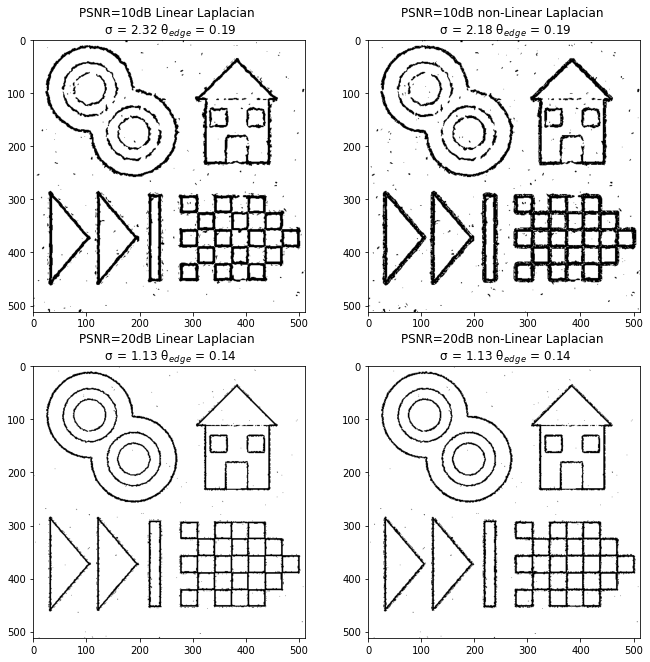

In [11]:
#plotting the optimal combos for each case

Α1 = EdgeDetect(noisy1, 2.32, 0.19, 1)
Α2 = EdgeDetect(noisy1, 2.18, 0.19, 2)
Β1 = EdgeDetect(noisy2, 1.13, 0.14, 1)
Β2 = EdgeDetect(noisy2, 1.13, 0.14, 2)

plt.figure(figsize=(11,11))

plt.subplot(2,2,1)
plt.imshow(Α1, cmap = 'gray_r')
plt.title('PSNR=10dB Linear Laplacian \n σ = 2.32 θ$_e$$_d$$_g$$_e$ = 0.19');

plt.subplot(2,2,2)
plt.imshow(Α2, cmap = 'gray_r')
plt.title('PSNR=10dB non-Linear Laplacian \n σ = 2.18 θ$_e$$_d$$_g$$_e$ = 0.19');

plt.subplot(2,2,3)
plt.imshow(Β1, cmap = 'gray_r')
plt.title('PSNR=20dB Linear Laplacian \n σ = 1.13 θ$_e$$_d$$_g$$_e$ = 0.14');

plt.subplot(2,2,4)
plt.imshow(Β2, cmap = 'gray_r')
plt.title('PSNR=20dB non-Linear Laplacian \n σ = 1.13 θ$_e$$_d$$_g$$_e$ = 0.14');

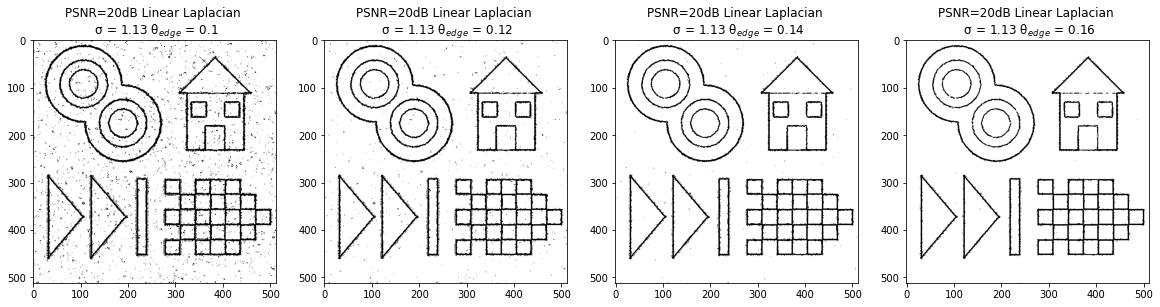

In [12]:
#plotting for different thetas to see its effect

plt.figure(figsize=(20,11))

plt.subplot(1,4,1)
plt.imshow(EdgeDetect(noisy2, 1.13, 0.1, 1), cmap = 'gray_r')
plt.title('PSNR=20dB Linear Laplacian \n σ = 1.13 θ$_e$$_d$$_g$$_e$ = 0.1');

plt.subplot(1,4,2)
plt.imshow(EdgeDetect(noisy2, 1.13, 0.12, 1), cmap = 'gray_r')
plt.title('PSNR=20dB Linear Laplacian \n σ = 1.13 θ$_e$$_d$$_g$$_e$ = 0.12');

plt.subplot(1,4,3)
plt.imshow(EdgeDetect(noisy2, 1.13, 0.14, 1), cmap = 'gray_r')
plt.title('PSNR=20dB Linear Laplacian \n σ = 1.13 θ$_e$$_d$$_g$$_e$ = 0.14');

plt.subplot(1,4,4)
plt.imshow(EdgeDetect(noisy2, 1.13, 0.16, 1), cmap = 'gray_r')
plt.title('PSNR=20dB Linear Laplacian \n σ = 1.13 θ$_e$$_d$$_g$$_e$ = 0.16');

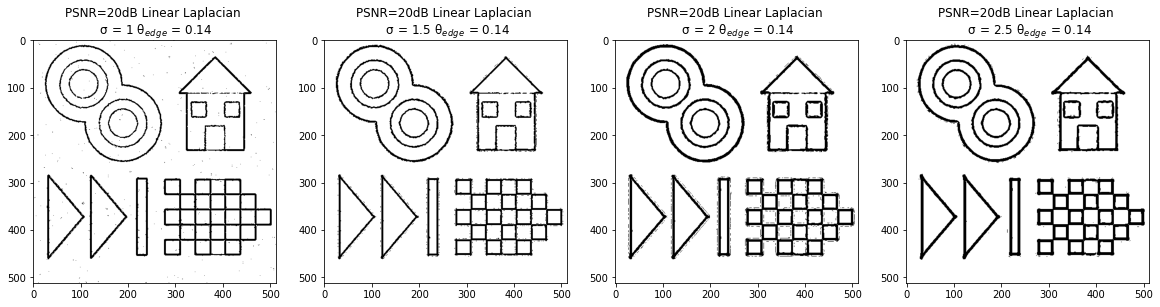

In [13]:
#plotting for different sigmas to see its effect

plt.figure(figsize=(20,11))

plt.subplot(1,4,1)
plt.imshow(EdgeDetect(noisy2, 1, 0.14, 1), cmap = 'gray_r')
plt.title('PSNR=20dB Linear Laplacian \n σ = 1 θ$_e$$_d$$_g$$_e$ = 0.14');

plt.subplot(1,4,2)
plt.imshow(EdgeDetect(noisy2, 1.5, 0.14, 1), cmap = 'gray_r')
plt.title('PSNR=20dB Linear Laplacian \n σ = 1.5 θ$_e$$_d$$_g$$_e$ = 0.14');

plt.subplot(1,4,3)
plt.imshow(EdgeDetect(noisy2, 2, 0.14, 1), cmap = 'gray_r')
plt.title('PSNR=20dB Linear Laplacian \n σ = 2 θ$_e$$_d$$_g$$_e$ = 0.14');

plt.subplot(1,4,4)
plt.imshow(EdgeDetect(noisy2, 2.5, 0.14, 1), cmap = 'gray_r')
plt.title('PSNR=20dB Linear Laplacian \n σ = 2.5 θ$_e$$_d$$_g$$_e$ = 0.14');

In [14]:
#(1.3.3)
#Εφαρμογή της συνάρτησης στην εικόνα duomo και πειραματισμός για διάφορες τιμές σ και θ
#το loop αυτό παίρνει ώρα να τρέξει και για αυτό το βάλαμε όλο ως σχόλιο

#img = cv2.imread('duomo_edges.jpg', cv2.IMREAD_GRAYSCALE)
#img = img.astype(np.float)/255
#i=0
#j=0
#fig, ax = plt.subplots(4, 5, figsize = (100,100))
#t = [0.02, 0.04, 0.06, 0.08]
#s1 = [1.5, 1.6, 1.7, 2, 3]
#for k in range(4):
#    for l in range(5):
#        theta = t[k]
#        s = s1[l]
#        K1 = EdgeDetect(img, s, theta, 1)
#        #K2 = EdgeDetect(img, s, theta, 2)
#        #print ("theta edge =", theta)
#        #print ("Outputs of real image:")
#
#        ax[i,j].imshow(K1, cmap='gray_r')
#        #ax[1].imshow(K2, cmap='gray_r')
#        ax[i,j].set_title("theta = %1.3f" % theta + " and s = %1.3f" % s)
#        #ax[1].set_title("Non-linear Estimation of Laplacian")
#        j=j+1
#    j=0
#    i=i+1

C:\Users\grgsl\anaconda3\envs\cv_lab1_env\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'theta = 0.080 and s = 3.000')

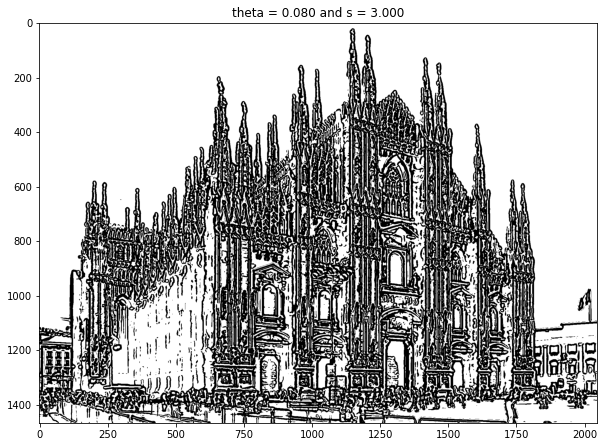

In [15]:
#plotting the edge detection results for real image

img = cv2.imread('duomo_edges.jpg', cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float)/255

theta = 0.08
s = 3

K1 = EdgeDetect(img, s, theta, 1)

plt.figure(figsize=(10,10))
plt.imshow(K1, cmap='gray_r')
plt.title("theta = %1.3f" % theta + " and s = %1.3f" % s)